_This notebook contains code and comments from Section 2.2 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## 2.5 Case Study: Breast Cancer Diagnosis

Our first case study explores a medical decision-making task: breast cancer diagnosis. We will see how to use scikit-learn’s homogeneous parallel ensemble modules in practice.  Specifically, we will train and evaluate the performance of three homogeneous parallel algorithms, each characterized by increasing randomness: bagging with decision trees, random forests and ExtraTrees.

Breast-cancer diagnosis is the task of classifying patient tumor data into one of two classes: **malignant** vs. **benign**. This task (and similar medical tasks) are at the core of **medical diagnostic decision-support systems** that are beginning to come into wider use in the healthcare industry. Such machine-learning algorithms can greatly minimize the false negative rate (where patients who do have cancer are misdiagnosed until too late) and improve chances for treatment and survival.

This task is challenging owing to subtle variations in patient data, which makes it very difficult for a single model to achieve high performance. Bagging and random forests are able to learn effective models. This case study will be tackled using scikit-learn’s implementations of bagging and random forests. The performance of these learned ensemble models will be compared with individual (non-ensemble / traditional) machine-learning models. Results will be used to show that ensemble methods can significantly outperform individual models, thus giving the reader a concrete, real-world example of how ensembles can be successful.

---

### 2.5.1 Loading and pre-processing

In [1]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

# Convert to a Pandas DataFrame so we can visualize nicely
import pandas as pd
import numpy as np
df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
i = np.random.permutation(len(dataset['target']))
df = df.iloc[i, :7]
df['diagnosis'] = dataset['target'][i]
df = df.reset_index()
df.head()

,index,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,diagnosis
0,554,12.88,28.92,82.50,514.3,0.08123,0.05824,0.06195,1
1,407,12.85,21.37,82.63,514.5,0.07551,0.08316,0.06126,1
2,246,13.20,17.43,84.13,541.6,0.07215,0.04524,0.04336,1
3,55,11.52,18.75,73.34,409.0,0.09524,0.05473,0.03036,1
4,324,12.20,15.21,78.01,457.9,0.08673,0.06545,0.01994,1


Pre-process the data by standardizing the features to be zero mean and unit standard deviation.

In [2]:
from sklearn.preprocessing import StandardScaler
X, y = dataset['data'], dataset['target']
X = StandardScaler().fit_transform(X)

---

### 2.5.2 Bagging, Random Forest and ExtraTrees

Once we have pre-processed our data set, we will train and evaluate bagging with decision trees, random forests and ExtraTrees in order to answer the following questions:
1.	How does the ensemble performance change with ensemble size? That is, what happens when our ensembles get bigger and bigger?
2.	How does the ensemble performance change with base learner complexity? That is, what happens when our individual base estimators become more and more complex. In this case study, since all three ensemble methods considered use decision trees as base estimators, one “measure” of complexity is tree depth, with deeper trees being more complex.

#### Ensemble size vs. ensemble performance
We compare the behavior of the three algorithms as the parameter ``n_estimators`` increases. 

**Listing 2.5**: Training and test errors with increasing ensemble size. 

**CAUTION: This experiment below runs slowly! Pickle files from a previous run are included for quick plotting.**

In [3]:
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score

if not os.path.exists('./data/ErrorVsNumEstimators.pickle'):
    max_leaf_nodes = 8
    n_runs = 20
    n_estimator_range = range(2, 20, 1)

    bag_trn_error = np.zeros((n_runs, len(n_estimator_range)))  # Train error for the bagging classifier
    rf_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the random forest classifier
    xt_trn_error = np.zeros((n_runs, len(n_estimator_range)))   # Train error for the extra trees classifier

    bag_tst_error = np.zeros((n_runs, len(n_estimator_range)))  # Test error for the bagging classifier
    rf_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the random forest classifier
    xt_tst_error = np.zeros((n_runs, len(n_estimator_range)))   # Test error for the extra trees classifier

    for run in range(0, n_runs):
        print('Run {0}'.format(run))

        # Split into train and test sets
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25)

        for j, n_estimators in enumerate(n_estimator_range):
            # Train using bagging
            bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                        n_estimators=n_estimators, max_samples=0.5, n_jobs=-1)
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            # Train using random forests
            rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                            n_estimators=n_estimators, n_jobs=-1)
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            # Train using extra trees
            xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                          n_estimators=n_estimators, n_jobs=-1)
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))

        results = (bag_trn_error, bag_tst_error, \
                   rf_trn_error, rf_tst_error, \
                   xt_trn_error, xt_tst_error)

    with open('./data/ErrorVsNumEstimators.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)
        
else:
    with open('./data/ErrorVsNumEstimators.pickle', 'rb') as result_file:
        (bag_trn_error, bag_tst_error, \
         rf_trn_error, rf_tst_error, \
         xt_trn_error, xt_tst_error) = pickle.load(result_file)

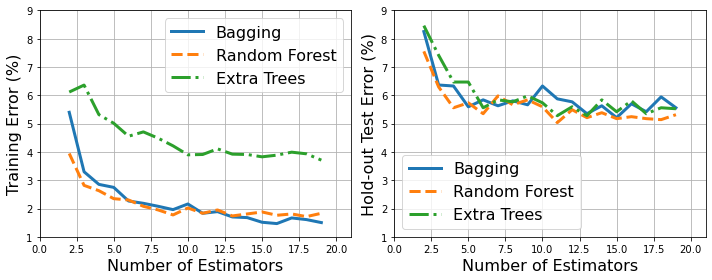

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_estimator_range = range(2, 20, 1)

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linewidth=3)

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linestyle='--', linewidth=3)

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_estimator_range, m, linestyle='-.', linewidth=3)

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=16)
ax[0].set_xlabel('Number of Estimators', fontsize=16)
ax[0].set_ylabel('Training Error (%)', fontsize=16)
ax[0].axis([0, 21, 1, 9])
ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linewidth=3)

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linestyle='--', linewidth=3)

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_estimator_range, m, linestyle='-.', linewidth=3)

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=16)
ax[1].set_xlabel('Number of Estimators', fontsize=16)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=16)
ax[1].grid()
ax[1].axis([0, 21, 1, 9]);
plt.tight_layout()

plt.savefig('./figures/CH02_F11_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

#### Base learner complexity vs. ensemble performance
Next, we compare the behavior of the three algorithms as the complexity of the base learners increases. There are several ways to control the complexity of the base decision trees: maximum depth, maximum number of leaf nodes, impurity criteria etc. Here, we compare the performance of the three ensemble methods as with complexity as determined by ``max_leaf_nodes``. 

**Unlisted**: Compare the performance of bagging, random forests and extra trees on the breast cancer data set with increasing bag size. The maximum number of estimators is fixed to 10, which ensures that all three ensemble methods have the same number of estimators in the ensemble.

**CAUTION: This experiment below runs slowly! Pickle files from a previous run are included for quick plotting.**

In [5]:
# See if the result file for this experiment already exists, and if not, rerun and save
# a new set of results
if not os.path.exists('./data/ErrorVsNumLeaves.pickle'):
    n_estimators = 10
    max_leaf_nodes = 8
    n_runs = 20
    n_leaf_range = [2, 4, 8, 16, 24, 32]

    bag_trn_error = np.zeros((n_runs, len(n_leaf_range)))  # Train error for the bagging classifier
    rf_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the random forest classifier
    xt_trn_error = np.zeros((n_runs, len(n_leaf_range)))   # Train error for the extra trees classifier

    bag_tst_error = np.zeros((n_runs, len(n_leaf_range)))  # Test error for the bagging classifier
    rf_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the random forest classifier
    xt_tst_error = np.zeros((n_runs, len(n_leaf_range)))   # Test error for the extra trees classifier

    for run in range(0, n_runs):
        print('Run {0}'.format(run))

        # Split into train and test sets
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.25)

        for j, max_leaf_nodes in enumerate(n_leaf_range):
            # Train using bagging
            bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes),
                                        n_estimators=n_estimators, max_samples=0.5, n_jobs=-1)
            bag_clf.fit(X_trn, y_trn)
            bag_trn_error[run, j] = 1 - accuracy_score(y_trn, bag_clf.predict(X_trn))
            bag_tst_error[run, j] = 1 - accuracy_score(y_tst, bag_clf.predict(X_tst))

            # Train using random forests
            rf_clf = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, 
                                            n_estimators=n_estimators, n_jobs=-1)
            rf_clf.fit(X_trn, y_trn)
            rf_trn_error[run, j] = 1 - accuracy_score(y_trn, rf_clf.predict(X_trn))
            rf_tst_error[run, j] = 1 - accuracy_score(y_tst, rf_clf.predict(X_tst))

            # Train using extra trees
            xt_clf = ExtraTreesClassifier(max_leaf_nodes=max_leaf_nodes, bootstrap=True,
                                          n_estimators=n_estimators, n_jobs=-1)
            xt_clf.fit(X_trn, y_trn)
            xt_trn_error[run, j] = 1 - accuracy_score(y_trn, xt_clf.predict(X_trn))
            xt_tst_error[run, j] = 1 - accuracy_score(y_tst, xt_clf.predict(X_tst))
            
        results = (bag_trn_error, bag_tst_error, \
                   rf_trn_error, rf_tst_error, \
                   xt_trn_error, xt_tst_error)
            
    with open('./data/ErrorVsNumLeaves.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)
        
else:
    with open('./data/ErrorVsNumLeaves.pickle', 'rb') as result_file:
        (bag_trn_error, bag_tst_error, \
         rf_trn_error, rf_tst_error, \
         xt_trn_error, xt_tst_error) = pickle.load(result_file)

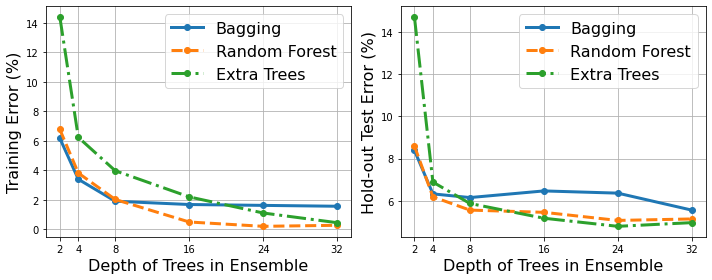

In [6]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
n_leaf_range = [2, 4, 8, 16, 24, 32]

# Plot the training error
m = np.mean(bag_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linewidth=3, marker='o')

m = np.mean(rf_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linestyle='--', linewidth=3, marker='o')

m = np.mean(xt_trn_error*100, axis=0)
ax[0].plot(n_leaf_range, m, linestyle='-.', linewidth=3, marker='o')

ax[0].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=16)
ax[0].set_xlabel('Depth of Trees in Ensemble', fontsize=16)
ax[0].set_ylabel('Training Error (%)', fontsize=16)
ax[0].set_xticks(n_leaf_range)
ax[0].grid()

# Plot the test error
m = np.mean(bag_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linewidth=3, marker='o')

m = np.mean(rf_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linestyle='--', linewidth=3, marker='o')

m = np.mean(xt_tst_error*100, axis=0)
ax[1].plot(n_leaf_range, m, linestyle='-.', linewidth=3, marker='o')

ax[1].legend(['Bagging', 'Random Forest', 'Extra Trees'], fontsize=16)
ax[1].set_xlabel('Depth of Trees in Ensemble', fontsize=16)
ax[1].set_ylabel('Hold-out Test Error (%)', fontsize=16)
ax[1].set_xticks(n_leaf_range)
ax[1].grid();
plt.tight_layout()

plt.savefig('./figures/CH02_F12_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

---

### 2.5.3	Feature importances with Random Forests

Finally, we see how we can use feature importances to identify the most predictive features for breast cancer diagnosis using the random forest ensemble. Such analysis adds interpretability to the model and can be very helpful in communicating and explaining such models to domain experts such as doctors.

#### Feature importances with label correlations
First, let’s peek into the data set to see if we can discover some interesting relationships among the features and the diagnosis. This type of analysis is typical when we get a new data set, as we try to learn more about it. Here, our analysis will try to identify which features are most correlated with each other and with the diagnosis (label), so that we can check if random forests can do something similar. 

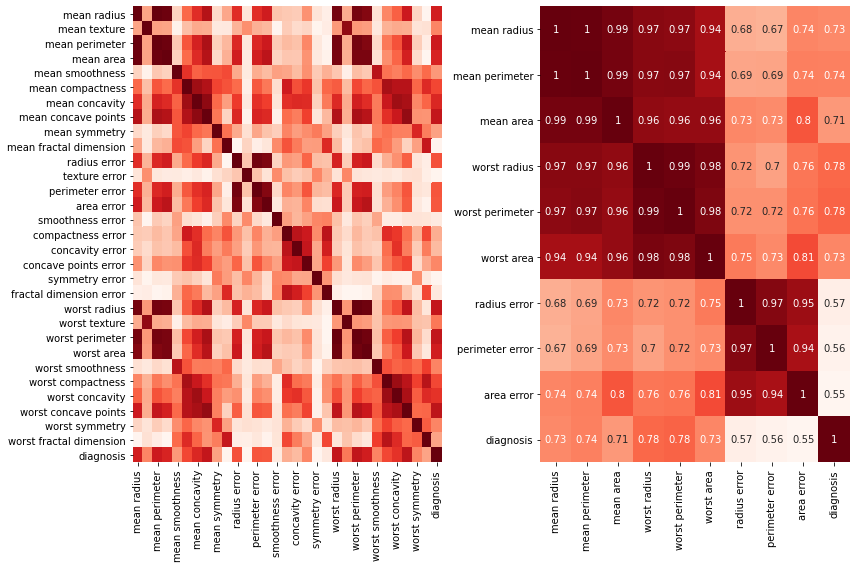

In [7]:
%matplotlib inline

import seaborn as sea

df = pd.DataFrame(data=dataset['data'], columns=dataset['feature_names'])
df['diagnosis'] = dataset['target'] 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
cor = np.abs(df.corr())
sea.heatmap(cor, annot=False, cbar=False, cmap=plt.cm.Reds, ax=ax[0])


f = ['mean radius', 'mean perimeter', 'mean area', \
     'worst radius', 'worst perimeter', 'worst area', \
     'radius error', 'perimeter error', 'area error', 'diagnosis']
cor_zoom = np.abs(df[f].corr())
sea.heatmap(cor_zoom, annot=True, cbar=False, cmap=plt.cm.Reds, ax=ax[1])
fig.tight_layout()

plt.savefig('./figures/CH02_F13_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');

There are several features that are also highly correlated with the label, that is, the diagnosis as benign or malignant. Let’s identify the 10 features most correlated with the diagnosis label.

In [8]:
label_corr = cor.iloc[:, -1]
label_corr.sort_values(ascending=False)[1:11]

worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
Name: diagnosis, dtype: float64

#### Feature importances using random forests
Random forests can also provide feature importances. The listing below illustrates this.

**Listing 2.7**: Feature importances in the WDBC data set using random forests

In [9]:
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.15)
n_features = X_trn.shape[1]

rf = RandomForestClassifier(max_leaf_nodes=24, n_estimators=50, n_jobs=-1)
rf.fit(X_trn, y_trn)
err = 1 - accuracy_score(y_tst, rf.predict(X_tst))
print('Prediction Error = {0:4.2f}%'.format(err*100))

importance_threshold = 0.02
for i, (feature, importance) in enumerate(zip(dataset['feature_names'],
                                              rf.feature_importances_)):

    if importance > importance_threshold:
        print('[{0}] {1} (score={2:4.3f})'.format(i, feature, importance))

Prediction Error = 4.65%
[0] mean radius (score=0.077)
[1] mean texture (score=0.020)
[2] mean perimeter (score=0.045)
[3] mean area (score=0.041)
[5] mean compactness (score=0.026)
[6] mean concavity (score=0.036)
[7] mean concave points (score=0.120)
[13] area error (score=0.020)
[20] worst radius (score=0.193)
[22] worst perimeter (score=0.138)
[23] worst area (score=0.054)
[26] worst concavity (score=0.027)
[27] worst concave points (score=0.096)


We can plot the feature importances as identified by the random forest ensemble

[0] mean radius (score=0.077)
[1] mean texture (score=0.020)
[2] mean perimeter (score=0.045)
[3] mean area (score=0.041)
[5] mean compactness (score=0.026)
[6] mean concavity (score=0.036)
[7] mean concave points (score=0.120)
[13] area error (score=0.020)
[20] worst radius (score=0.193)
[22] worst perimeter (score=0.138)
[23] worst area (score=0.054)
[26] worst concavity (score=0.027)
[27] worst concave points (score=0.096)


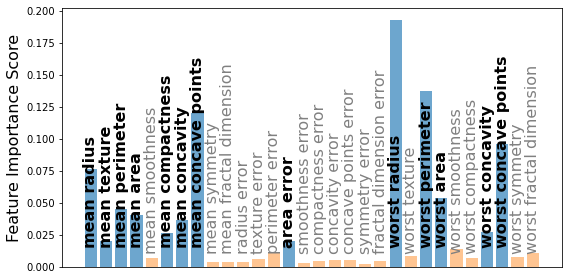

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Identify the important features
importance_threshold = 0.02
idx = np.array(range(n_features))
imp = np.where(rf.feature_importances_ >= importance_threshold)  # important features
rest = np.setdiff1d(idx, imp)  # remaining features

# Plot the important features and the rest on a bar chart
plt.bar(idx[imp], rf.feature_importances_[imp], alpha=0.65)
plt.bar(idx[rest], rf.feature_importances_[rest], alpha=0.45)

# Print feature names on the bar chart
for i, (feature, importance) in enumerate(zip(dataset['feature_names'], rf.feature_importances_)):
    if importance > importance_threshold:
        plt.text(i, 0.015, feature, ha='center', va='bottom', rotation='vertical', fontsize=16, fontweight='bold')
        print('[{0}] {1} (score={2:4.3f})'.format(i, feature, importance))
    else:
        plt.text(i, 0.01, feature, ha='center', va='bottom', rotation='vertical', fontsize=16, color='gray')
    
# Finish the plot    
fig.axes[0].get_xaxis().set_visible(False)
plt.ylabel('Feature Importance Score', fontsize=16)
plt.xlabel('Features for Breast Cancer Diagnosis', fontsize=16);

plt.tight_layout()
plt.savefig('./figures/CH02_F14_Kunapuli.png', format='png', dpi=300, bbox_inches='tight');